# Lung-cancer - Gene expression data pre-processing (RNAseq)


The following step only works in RStudio. If working in another environment, please set the working directory properly and check if the working directory is correct!

In [ ]:
# set wd to where script file is saved
setwd(dirname(rstudioapi::callFun("getActiveDocumentContext")$path))

In [1]:
# check wd
getwd()

[1] "C:/Users/Laurent/Jupyter-DataPreProcessing/Lung-cancer (RNAseq)"

In [2]:
# load libraries
library(readxl)
library(edgeR)
library(data.table)
library(biomaRt)
library(dplyr)

Warning message:
"package 'readxl' was built under R version 3.5.2"Warning message:
"package 'edgeR' was built under R version 3.5.2"Loading required package: limma
Warning message:
"package 'data.table' was built under R version 3.5.2"
Attaching package: 'dplyr'

The following object is masked from 'package:biomaRt':

    select

The following objects are masked from 'package:data.table':

    between, first, last

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



In [3]:
# read data table
data <- as.data.frame(read_excel(file.path(getwd(), "Data", "data-lung-cancer.xlsx")))
row.names(data) <- data$ENSG_ID

In [5]:
# run EdgeR
group <- factor(c(rep("case", 6), rep("control", 6)))
y <- DGEList(counts = data[,2:13], group = group)
y <- calcNormFactors(y)
design <- model.matrix(~group)
y <- estimateDisp(y, design)
fit <- glmQLFit(y, design)
qlf <- glmQLFTest(fit, coef = 2)
res <- as.data.frame(topTags(qlf,n=Inf))

In [6]:
# add row names as 1st column
res <- setDT(res, keep.rownames = TRUE)[]
colnames(res)[1] <- "GeneID"

In [7]:
# add HGNC symbols
mart <- useDataset("hsapiens_gene_ensembl", useMart("ensembl"))
genes <- res$GeneID
G_list <- getBM(filters= "ensembl_gene_id", attributes= c("ensembl_gene_id","hgnc_symbol"),values=genes,mart= mart)
res <- merge(res,G_list,by.x="GeneID",by.y="ensembl_gene_id")

head(res)
dim(res)

GeneID,logFC,logCPM,F,PValue,FDR,hgnc_symbol
ENSG00000000003,1.2109203,5.511086,5.58916076,3.028582e-02,0.201038947,TSPAN6
ENSG00000000005,1.6015344,-3.289581,2.03992682,1.713982e-01,0.444140353,TNMD
ENSG00000000419,0.4674649,4.989019,1.17212668,2.941380e-01,0.564898506,DPM1
ENSG00000000457,0.0544462,3.877977,0.01912656,8.916352e-01,1.000000000,SCYL3
ENSG00000000460,1.4376887,2.534168,10.94382106,4.173094e-03,0.100584579,C1orf112
ENSG00000000938,-2.9959429,6.392048,43.04053693,4.943410e-06,0.005027991,FGR


[1] 56760     7

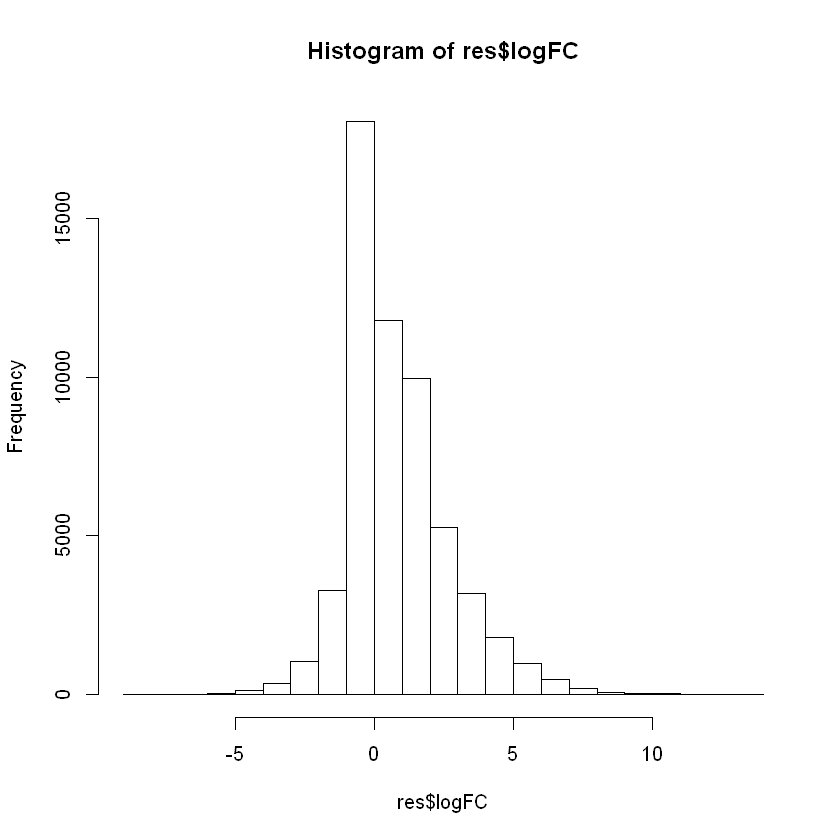

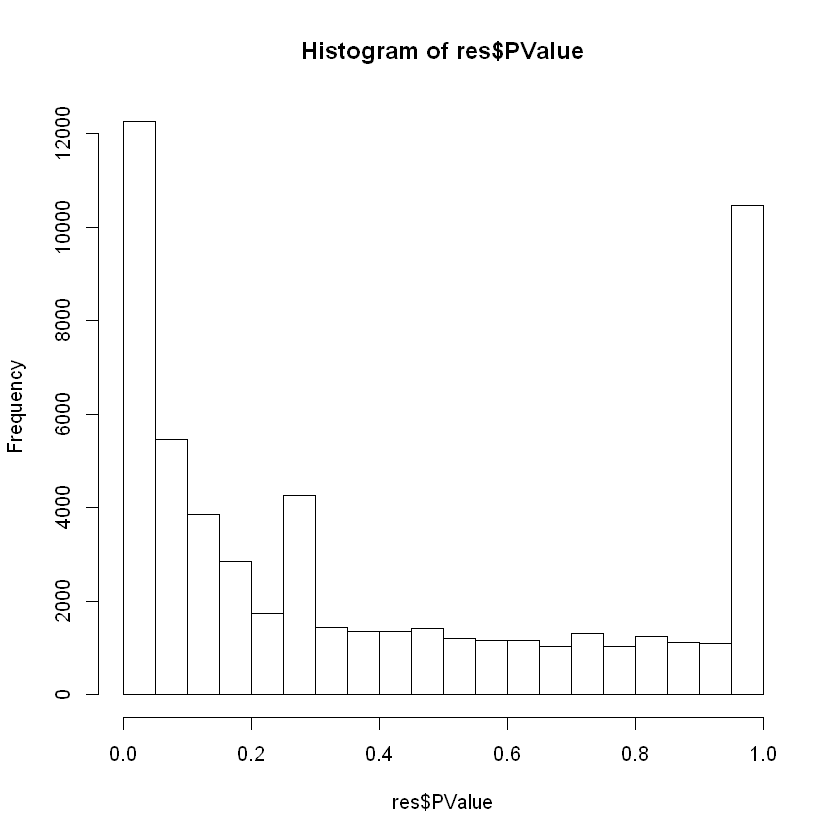

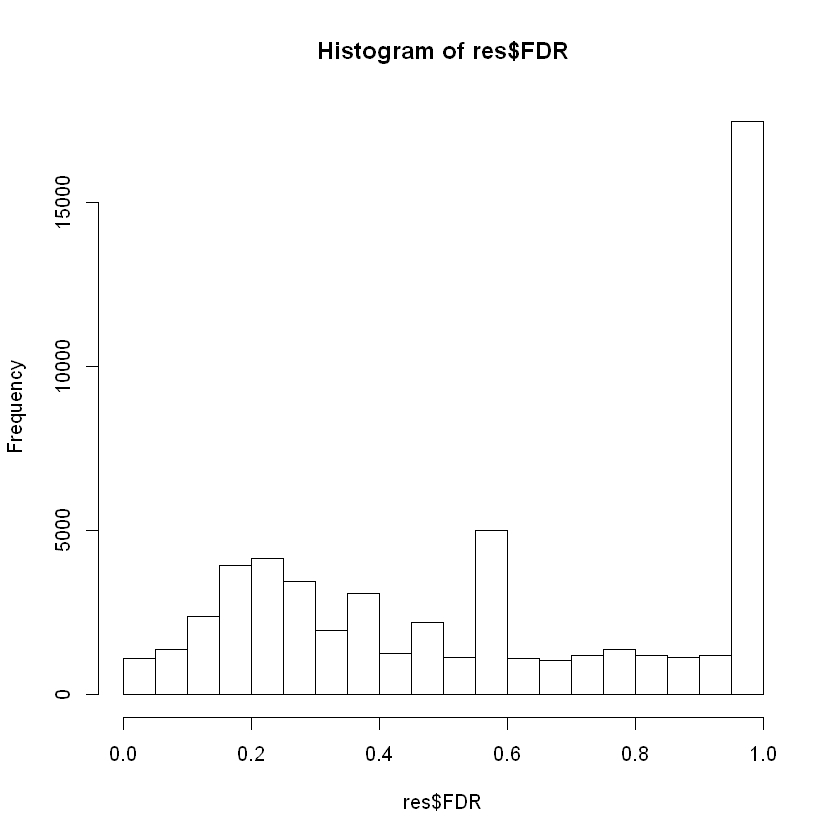

In [8]:
# check histograms of statistics
hist(res$logFC)
hist(res$PValue)
hist(res$FDR)

In [9]:
# save result
write.table(res, file.path(getwd(), "Data", "Stats", "lung-cancer_stats.txt"), quote=F, sep="\t", col.names=T, row.names=F)